In [39]:
import os 
import glob
import cv2
import json 
import numpy as np
import shutil
import imageio as io
from squaternion import Quaternion
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.gridspec import GridSpec
import math 
from cityscapesscripts.helpers.annotation import CsBbox3d
from cityscapesscripts.helpers.box3dImageTransform import (
    Camera, 
    Box3dImageTransform,
    CRS_V,
    CRS_C,
    CRS_S
)

IMAGE_DIR    = "/home/lab530/KenYu/SOLO/cityscapes/leftImg8bit/"
LABEL_DIR    = "/home/lab530/KenYu/SOLO/cityscapes/gtFine_trainvaltest/gtFine/"
LABEL_3D_DIR = "/home/lab530/KenYu/SOLO/cityscapes/gtBbox3d/"

class Object:
    def __init__(self, obj_json, box3d_annotation,  idx_img = None):
        # Create a CsBox3d object for the 3D annotation
        obj = CsBbox3d()
        

        # TODO TODO tmp
        q1, q2, q3, q4 = obj_json["3d"]["rotation"]
        q = Quaternion(q1, q2, q3, q4)
        _, _, self.rot_y = q.to_euler() # Raw, pitch, yaw
        q = Quaternion.from_euler(0, 0, self.rot_y)
        obj_json["3d"]["rotation"] = [q[0], q[1], q[2], q[3]]


        obj.fromJsonText(obj_json)
        # Initialize the 3D box with an annotation in coordinate system V. 
        # You can alternatively pass CRS_S or CRS_C if you want to initalize the box in a different coordinate system.
        # Please note that the object's size is always given as [L, W, H] independently of the used coodrinate system.
        box3d_annotation.initialize_box_from_annotation(obj, coordinate_system=CRS_V)
        size_S, center_S, _          = box3d_annotation.get_parameters(coordinate_system=CRS_S)
        _     , _       , rotation_C = box3d_annotation.get_parameters(coordinate_system=CRS_C)
        # 
        self.idx_img = idx_img
        self.obj_json = obj_json
        self.l, self.w, self.h       = size_S
        self.x3d, self.y3d, self.z3d = center_S
        self.y3d += self.h/2 # From 3Dbox center to bottom center

        q1, q2, q3, q4 = rotation_C
        q = Quaternion(q1, q2, q3, q4)
        _, _, self.rot_y = q.to_euler() # Raw, pitch, yaw
        self.rot_y = math.pi*3/2 - self.rot_y

        # "gt['modal']": [xmin, ymin, w, h],
        self.xmin, self.ymin, self.xmax, self.ymax = obj_json['2d']['amodal']
        self.xmax += self.xmin
        self.ymax += self.ymin

        self.occlusion = obj_json['occlusion']
        self.truncation = obj_json['truncation']
        self.instanceId = obj_json['instanceId']
        self.category = obj_json['label']
        # TODO Alpha?
        
        # Convert to KITTI format
        self.str_line = f"{self.category} {self.truncation} {self.occlusion} {0} {self.xmin} {self.ymin} {self.xmax} {self.ymax} {self.h} {self.w} {self.l} {self.x3d} {self.y3d} {self.z3d} {self.rot_y}"

        # self.area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        # self.corners = get_3d_box((self.l, self.w, self.h),
        #                            self.rot_y,
        #                           (self.x_3d, self.y_3d, self.z_3d))

def compute_3Dbox(P2, obj, box3d_annotation):
    # Draw 3D Bounding Box
    R = np.array([[ np.cos(obj.rot_y), 0, np.sin(obj.rot_y)],
                  [ 0                , 1, 0                ],
                  [-np.sin(obj.rot_y), 0, np.cos(obj.rot_y)]])
    
    x_corners = [0, obj.l, obj.l, obj.l, obj.l, 0,     0,     0]  # -l/2
    y_corners = [0, 0,     obj.h, obj.h, 0,     0,     obj.h, obj.h]  # -h
    z_corners = [0, 0,     0,     obj.w, obj.w, obj.w, obj.w, 0]  # -w/2

    x_corners = [i - obj.l / 2 for i in x_corners]
    y_corners = [i - obj.h     for i in y_corners]
    z_corners = [i - obj.w / 2 for i in z_corners]

    corners_3D = np.array([x_corners, y_corners, z_corners])
    corners_3D = R.dot(corners_3D)
    corners_3D += np.array([obj.x3d, obj.y3d, obj.z3d]).reshape((3, 1))

    # Avoid z_3d < 0, saturate at 0.0001
    corners_3D[2] = np.array([max(0.0001, i) for i in corners_3D[2]])
    # 
    corners_3D_1 = np.vstack((corners_3D, np.ones((corners_3D.shape[-1]))))
    
    print(f"corners_3D KITTI Format = {corners_3D_1}")
    print(f"KITTI Foramt = {(obj.x3d, obj.y3d, obj.z3d)}")

    corners_3D_tmp = box3d_annotation.get_vertices(coordinate_system=CRS_S)
    corners_3D_citi = [[], [], []]
    for corners_name in ['BLB', 'FLB', 'FLT', 'FRT', 'FRB', 'BRB', 'BRT', 'BLT']:
        corners_3D_citi[0].append(corners_3D_tmp[corners_name][0])
        corners_3D_citi[1].append(corners_3D_tmp[corners_name][1])
        corners_3D_citi[2].append(corners_3D_tmp[corners_name][2])
    corners_3D_citi = np.array(corners_3D_citi)
    print(f"corners_3D Citi Foramt = {corners_3D_citi}")
    # TODO 
    # corners_3D_1 = np.vstack((corners_3D_citi, np.ones((corners_3D_citi.shape[-1]))))

    x_c = (corners_3D_1[0, 0] + corners_3D_1[0, 1] + corners_3D_1[0, 4] + corners_3D_1[0, 5]) / 4.0
    y_c = (corners_3D_1[1, 0] + corners_3D_1[1, 1] + corners_3D_1[1, 4] + corners_3D_1[1, 5]) / 4.0
    z_c = (corners_3D_1[2, 0] + corners_3D_1[2, 1] + corners_3D_1[2, 4] + corners_3D_1[2, 5]) / 4.0
    print(f"Citi Foramt = {(x_c, y_c, z_c)}")

    corners_2D = P2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]
    corners_2D = corners_2D[:2]
    
    corners_3D_citi = box3d_annotation.get_vertices(coordinate_system=CRS_S) 

    return corners_2D

def draw_3Dbox(ax, P2, obj, color, box3d_annotation):
    
    # # Draw 2D Bounding Box
    # xmin = int(obj.xmin)
    # xmax = int(obj.xmax)
    # ymin = int(obj.ymin)
    # ymax = int(obj.ymax)
    # width = xmax - xmin
    # height = ymax - ymin
    # box_2d = patches.Rectangle((xmin, ymin), width, height, fill=False, color='red', linewidth='1')
    # ax.add_patch(box_2d)
    
    # Using KITTI Format to computer 3d bbox
    corners_2D = compute_3Dbox(P2, obj, box3d_annotation)
    # print(f"KITTI Format : {corners_2D}")

    # Using cityscape toolkit to computer
    
    corners_2D_tmp = box3d_annotation.get_vertices_2d()
    corners_2D_true = [[], []]
    for corners_name in ['BLB', 'FLB', 'FLT', 'FRT', 'FRB', 'BRB', 'BRT', 'BLT']:
        corners_2D_true[0].append(corners_2D_tmp[corners_name][0])
        corners_2D_true[1].append(corners_2D_tmp[corners_name][1])
    corners_2D_true = np.array(corners_2D_true)
    print(f"citiscape format: {corners_2D_true}")

    # draw all lines through path
    # https://matplotlib.org/users/path_tutorial.html
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO
    # codes[-1] = Path.CLOSEPOLYq
    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=1)

    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    
    # put a mask on the front
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    
    ax.add_patch(p)
    ax.add_patch(front_fill)


total number of image = 3475
number of objects = 10
corners_3D KITTI Format = [[-4.58501641 -5.18530206 -5.18530206 -3.61330856 -3.61330856 -3.01302291
  -3.01302291 -4.58501641]
 [-2.28014106 -2.28014106 -0.81014106 -0.81014106 -2.28014106 -2.28014106
  -0.81014106 -0.81014106]
 [22.99709742 19.04239679 19.04239679 18.80378324 18.80378324 22.75848388
  22.75848388 22.99709742]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.        ]]
KITTI Foramt = (-4.09916248469557, -0.8101410624871667, 20.900440330794)
corners_3D Citi Foramt = [[-3.01322193 -3.61308398 -3.61308398 -5.18510303 -5.18510303 -4.58524099
  -4.58524099 -3.01322193]
 [-0.88126475 -0.73101985 -2.19995864 -2.20901737 -0.74007859 -0.89032349
  -2.35926228 -2.35020354]
 [22.78518205 18.83327214 18.77742558 19.01569861 19.07154516 23.02345508
  22.96760852 22.7293355 ]]
Citi Foramt = (-4.09916248469557, -2.2801410624871665, 20.900440330794)
citiscape format: [[797.77348609 662.925062   661.6

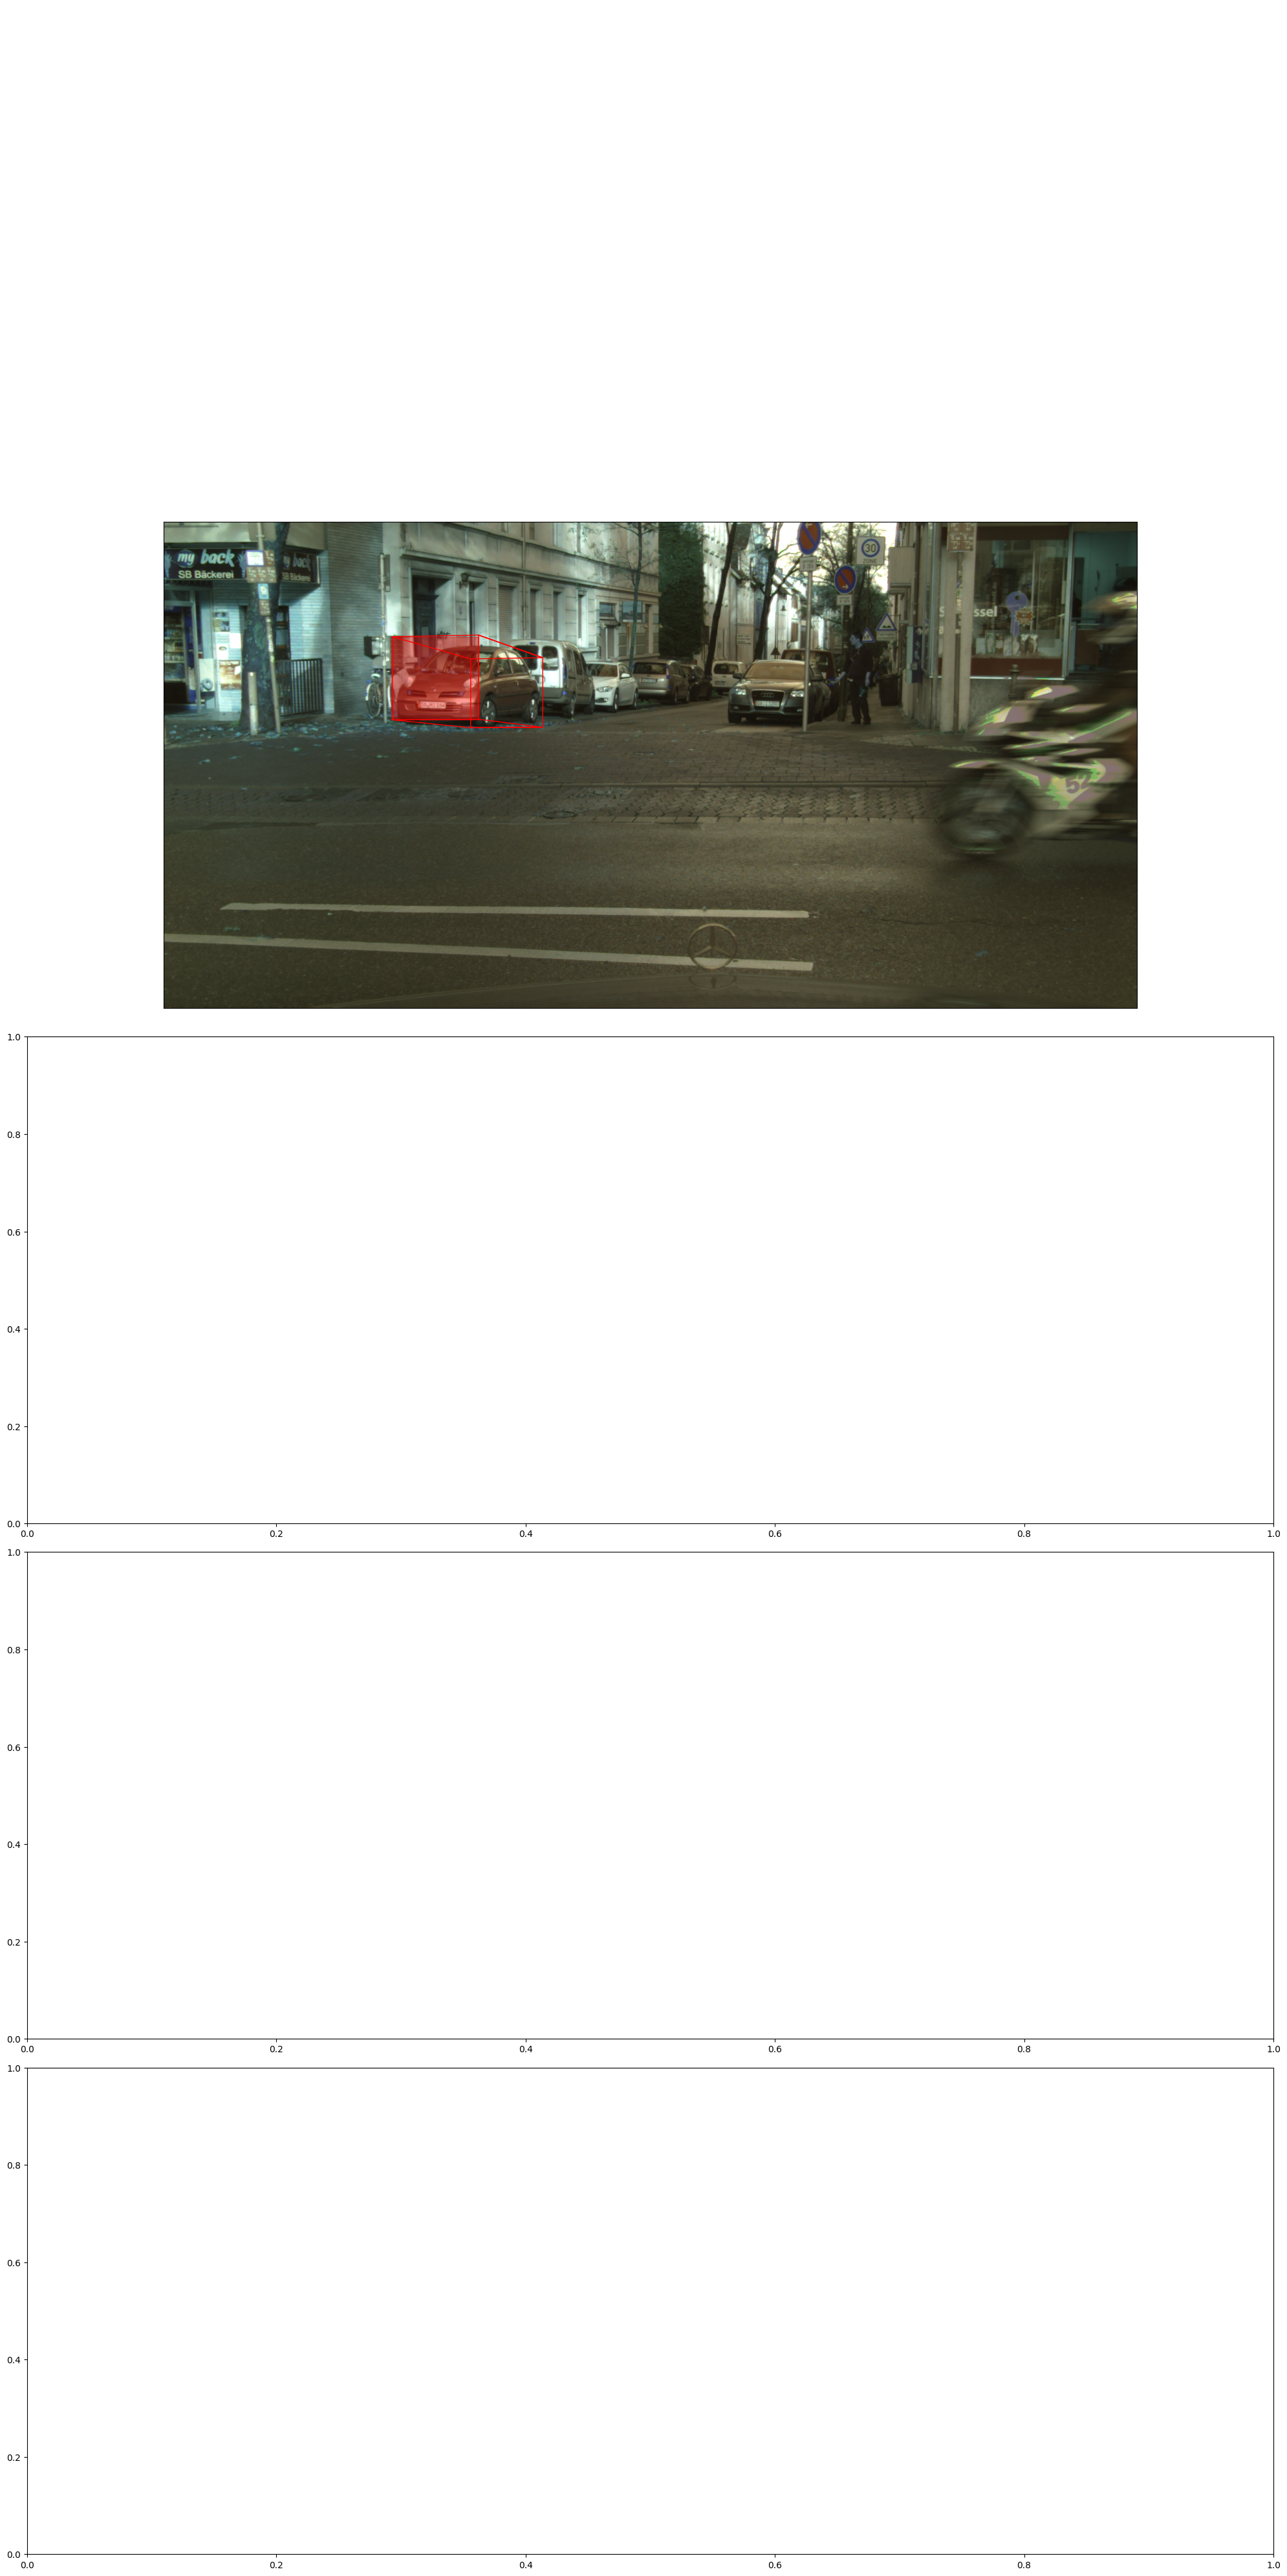

In [40]:

# Get all images
imgs_path = []
for i in os.listdir(IMAGE_DIR + 'train/'):
    imgs_path += glob.glob(f"{IMAGE_DIR}train/{i}/*.png")
for i in os.listdir(IMAGE_DIR + 'val/'):
    imgs_path += glob.glob(f"{IMAGE_DIR}val/{i}/*.png")
print(f"total number of image = {len(imgs_path)}")

fig, ax = plt.subplots(5, 1, figsize=(20, 40))
fig.set_facecolor('white')
fig.tight_layout()
ax[0].axis('off')

for idx, img_path in enumerate(imgs_path):
    if idx != 1 : continue # TODO 
     
    img = cv2.imread(img_path)
    img_name = img_path[img_path.rfind('/')+1:img_path.rfind('_')] # darmstadt_000058_000019

    with open(f"{LABEL_3D_DIR}{img_path.split('/')[-3]}/{img_path.split('/')[-2]}/{img_name}_gtBbox3d.json", newline='') as f:
        data = json.load(f)
        h = data['imgHeight']
        w = data['imgWidth']
        P2 = np.array([[data['sensor']['fx'], 0,                    data['sensor']['u0'], 0], 
                       [0,                    data['sensor']['fy'], data['sensor']['v0'], 0],
                       [0,                    0,                    1                   , 0]])

        print(f"number of objects = {len(data['objects'])}")
        
        camera = Camera(fx=data["sensor"]["fx"],
                        fy=data["sensor"]["fy"],
                        u0=data["sensor"]["u0"],
                        v0=data["sensor"]["v0"],
                        sensor_T_ISO_8855=data["sensor"]["sensor_T_ISO_8855"])
        # Create the Box3dImageTransform object
        box3d_annotation = Box3dImageTransform(camera=camera)
        
        for idx_gt, gt in enumerate(data['objects']):
            if idx_gt != 0 : continue
            # KITTI format
            obj = Object(gt, box3d_annotation)
            draw_3Dbox(ax[idx], P2, obj, (1, 0, 0), box3d_annotation)

    ax[idx].imshow(img)
    ax[idx].set_xticks([]) # remove axis value
    ax[idx].set_yticks([])


